In [28]:
from newsplease import NewsPlease
import requests
from bs4 import BeautifulSoup
import json
import re
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from textblob import TextBlob

# from selenium.webdriver import Chrome
# from selenium.webdriver.chrome.options import Options

In [2]:
from NewsSentiment import TargetSentimentClassifier
tsc = TargetSentimentClassifier()


/home/felipenuti/miniconda3/envs/group_practical/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# url = "https://coinmarketcap.com/currencies/ethereum/news/"

# chrome_options = Options()
# chrome_options.add_argument("--headless")

# with Chrome(options = chrome_options) as browser:
#     browser.get(url)
#     html = browser.page_source

# soup = BeautifulSoup(html, 'html.parser')

In [3]:
url = "https://api.coinmarketcap.com/content/v3/news?coins=1027&page=1&size=200"
res = requests.get(url)

In [4]:
news_data = json.loads(res.text)['data']
len(news_data)

200

In [15]:
def prepare_text(text):
    return [ x.strip().replace('\n', '') for x in re.split('\.[^0-9]', text) if x != '']

def find_sentiment(sentence, entity):
    output = tsc.infer(text_left = "", target_mention=entity, text_right = "\ "+ sentence)#article.maintext)
    results = ""
    pos = 0
    neg = 0
    for x in output:
        results += "{}: {} | ".format(x['class_label'], x['class_prob'])
        if x['class_label'] == 'negative':
            neg = x['class_prob']
        elif x['class_label'] == 'positive':
            pos = x['class_prob']
    return (results, [pos, neg])

def test_just_headline():
    idx = np.random.randint(0, len(news_data))
    example_news = news_data[idx]
    title = example_news['meta']['title']
    subtitle = example_news['meta']['subtitle']

    #title = title.replace(['\n', ' '], '')
    #subtitle = subtitle.replace(['\n', ' '], '')

    print(title)
    print(tsc.infer(text_left = '', target_mention = 'Ethereum', text_right = '\ '+title))
    print(subtitle)
    print(tsc.infer(text_left = title, target_mention = 'Ethereum', text_right =  '\ '+title))

def test_newsentiment():
    idx = np.random.randint(0, len(news_data))
    example_news = news_data[idx]
    print(example_news)
    article = NewsPlease.from_url(example_news['meta']['sourceUrl'])
    sentences = prepare_text(article.maintext)
    #print(sentences)
    n_sentences = len(sentences)
    sents = []
    for i, sentence in enumerate(sentences):
        if sentence == None:
            continue
        results_eth, point = find_sentiment(sentence, "Ethereum")
        results_btc, _ = find_sentiment(sentence, "Bitcoin")
        print(results_eth + "\n" + results_btc + "\n" + sentence + "\n")

        sents.append([i/n_sentences] + point)
        #left += ". " + sentence
    return np.array(sents)

In [24]:
test_just_headline()
# sents = test_newsentiment()

Dubai School Greenlights School Fee Payments In Crypto
[{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.7394821643829346}, {'class_id': 2, 'class_label': 'positive', 'class_prob': 0.2090846598148346}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.05143318325281143}]
Dubai&rsquo;s Citizens School has announced that it will be accepting school fee payments in BTC and ETH, becoming the first school in the Middle School to do so.&nbsp;
Pay Tuition Fees In BTC, ETH
The Citizens School, which is based in Dubai, will officially start operations in ...
[{'class_id': 1, 'class_label': 'neutral', 'class_prob': 0.45575278997421265}, {'class_id': 2, 'class_label': 'positive', 'class_prob': 0.4531610608100891}, {'class_id': 0, 'class_label': 'negative', 'class_prob': 0.09108614176511765}]


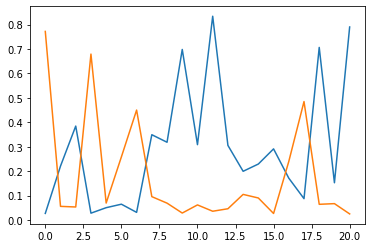

In [8]:
kde = KernelDensity(kernel = 'epanechnikov', bandwidth=100).fit(sents[:, [0, 1]])
plt.plot(sents[:, [1, 2]])

In [29]:
def test_textblob_headlines():
    idx = np.random.randint(0, len(news_data))
    example_news = news_data[idx]
    title = example_news['meta']['title'].strip()
    subtitle = example_news['meta']['subtitle'].strip()

    for sentence in [title, subtitle]:
        tb = TextBlob(sentence)
        output = tb.sentiment
        print(str(output) + " " + sentence + "\n")


def test_textblob():
    idx = np.random.randint(0, len(news_data))
    example_news = news_data[idx]
    article = NewsPlease.from_url(example_news['meta']['sourceUrl'])
    sentences = [ x.strip().replace('\n', '') for x in article.maintext.split('. ') if x != '']
    left = ""
    for sentence in sentences:
        tb = TextBlob(sentence)
        output = tb.sentiment
        print(str(output) + " " + sentence + "\n")
        left += ". " + sentence
    print(TextBlob(article.maintext).sentiment)

In [50]:
test_textblob_headlines()
#test_textblob()

Sentiment(polarity=0.0, subjectivity=0.0) Daily mined Ethereum is decreasing; Is a price rise on the cards?

Sentiment(polarity=-0.08333333333333333, subjectivity=0.4166666666666667) Ethereum (ETH) has been trading in the red for the past week, although a potential bullish turn could be waiting...  Continue reading



In [66]:
TextBlob("Ethereum is surreal").sentiment

Sentiment(polarity=0.25, subjectivity=1.0)

In [23]:
idx = np.random.randint(0, len(news_data))
example_news = news_data[idx]
article = NewsPlease.from_url(example_news['meta']['sourceUrl'])

In [24]:
example_news['meta']['sourceUrl']

'https://zycrypto.com/wen-merge-ethereum-wraps-up-major-allcoredevs-session-as-move-to-pos-propels-giant-strides/'

In [25]:
article.maintext

'Advertisement\nEthereum’s team has completed an AllCoreDev meeting with key areas of interest covered.\nThe call covered the shadow forks on Goerli and how to handle EL clients and difficulty bombs amongst others.\nEthereum is edging closer towards a transition to proof of stake in the near future.\nEthereum has inched towards the transition to the Proof-of-Stake Consensus Layer with the conclusion of another ‘AllCoreDevs’ session. The details were shared by top Ethereum programmer Tim Beiko and touched on several key areas.\nThe AllCoreDevs Call\nTim Beiko, a leading Ethereum developer hosted a meeting of core Ethereum devs that began with an update on the testing of the Merge hard fork. As part of the testing process, the developers “shadow forked” Goerli, allowing “client teams to experience issues with block production logic and differing timeout expectations.”\nThe shadow merge will allow devs to spot issues that might crop up easily and after two shadow forks, a third is being p

In [26]:
sentences = [ x.strip().replace('\n', '') for x in article.maintext.split('. ') if x != '']
sentences

['AdvertisementEthereum’s team has completed an AllCoreDev meeting with key areas of interest covered.The call covered the shadow forks on Goerli and how to handle EL clients and difficulty bombs amongst others.Ethereum is edging closer towards a transition to proof of stake in the near future.Ethereum has inched towards the transition to the Proof-of-Stake Consensus Layer with the conclusion of another ‘AllCoreDevs’ session',
 'The details were shared by top Ethereum programmer Tim Beiko and touched on several key areas.The AllCoreDevs CallTim Beiko, a leading Ethereum developer hosted a meeting of core Ethereum devs that began with an update on the testing of the Merge hard fork',
 'As part of the testing process, the developers “shadow forked” Goerli, allowing “client teams to experience issues with block production logic and differing timeout expectations.”The shadow merge will allow devs to spot issues that might crop up easily and after two shadow forks, a third is being planned 

In [30]:
for sentence in sentences:
    if sentence == None:
        continue
    output = tsc.infer(text_left = "", target_mention="Ethereum", text_right = " "+ sentence)#article.maintext)
    results = ""
    for x in output:
        results += "{}: {} | ".format(x['class_label'], x['class_prob'])
    print(results + " " + sentence + "\n")

positive: 0.5666216015815735 | neutral: 0.40359145402908325 | negative: 0.02978700026869774 |  AdvertisementEthereum’s team has completed an AllCoreDev meeting with key areas of interest covered.The call covered the shadow forks on Goerli and how to handle EL clients and difficulty bombs amongst others.Ethereum is edging closer towards a transition to proof of stake in the near future.Ethereum has inched towards the transition to the Proof-of-Stake Consensus Layer with the conclusion of another ‘AllCoreDevs’ session

neutral: 0.7989212274551392 | positive: 0.17525121569633484 | negative: 0.025827588513493538 |  The details were shared by top Ethereum programmer Tim Beiko and touched on several key areas.The AllCoreDevs CallTim Beiko, a leading Ethereum developer hosted a meeting of core Ethereum devs that began with an update on the testing of the Merge hard fork

neutral: 0.573657214641571 | negative: 0.22866269946098328 | positive: 0.19768007099628448 |  As part of the testing proces

In [29]:
s = json.loads(soup.find('script', id = '__NEXT_DATA__').text)

In [31]:
with open('test.html', 'w') as file:
    file.write(soup.prettify())

In [43]:
article.maintext.split([".", "\n"])

TypeError: must be str or None, not list

In [46]:
res = requests.head("https://coinmarketcap.com/currencies/ethereum/news/")

In [47]:
res.text

''

In [45]:
import torch.cuda

In [46]:
torch.cuda.empty_cache()